In [44]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import TensorBoard

In [45]:
import sys
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [60]:
def visualize_layer(model, layer_name):
    model = model
    margin = 5
    input_size = model.get_layer(layer_name).input_shape[1]
    # output_size = model.get_layer(layer_name).output_shape[1]
    channel = model.get_layer(layer_name).input_shape[3]
    num = len(model.get_layer(layer_name).get_weights()[1])
    row = num // 8 if num % 8 == 0 else num // 8 + 1
    rest_column = 8 if num % 8 == 0 else len(model.get_layer(layer_name).get_weights()[1]) % 8
    
    # This a empty (black) image where we will store our results.
    results = np.zeros((row * input_size + (row-1) * margin, 8 * input_size + 7 * margin, 3), dtype='uint8')

    for j in range(row):  # iterate over the rows of our results grid
        if j == row - 1:
            for i in range(rest_column):  # iterate over the columns of our results grid
                # Generate the pattern for filter `i + (j * 8)` in `layer_name`
                filter_img = generate_pattern(layer_name, i + (j * 8), size=input_size, channel=channel)
                filter_img = filter_img[:,:,-3:]

                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = j * input_size + j * margin
                horizontal_end = horizontal_start + input_size
                vertical_start = i * input_size + i * margin
                vertical_end = vertical_start + input_size
                results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        else:
            for i in range(8):  # iterate over the columns of our results grid
                # Generate the pattern for filter `i + (j * 8)` in `layer_name`
                filter_img = generate_pattern(model, layer_name, i + (j * 8), size=input_size, channel=channel)
                filter_img = filter_img[:,:,-3:]

                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = j * input_size + j * margin
                horizontal_end = horizontal_start + input_size
                vertical_start = i * input_size + i * margin
                vertical_end = vertical_start + input_size
                results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img       

    # Display the results grid
    results = results.astype('int')
    plt.figure(figsize=(24, 3 * row))
    plt.imshow(results)
    plt.show()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(model, layer_name, filter_index, size, channel):
    model = model
    channel = model.get_layer(layer_name).input_shape[3]
    # change model.input -> model.get_layer(layer_name).input
    # cf. https://keras.io/getting-started/functional-api-guide/#the-concept-of-layer-node

    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index]) 
    # 'layer_name'のfilter_indexの活性化に関する損失関数。

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.get_layer(layer_name).input)[0] # [0]->(1, 56, 56, 128)  ' ' -> (1, 1, 56, 56, 128)

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    channel = model.get_layer(layer_name).input_shape[3]
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, channel)) * 20 + 128.

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.get_layer(layer_name).input], [loss, grads])  

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])  
        input_img_data += grads_value * step # 損失が最大になるように入力画像を調整

    img = input_img_data[0]
    return deprocess_image(img) # 調整し終わった入力画像を返すので、出力は入力画像とサ同じサイズ！

In [47]:
from keras.models import load_model
generator = load_model('./saved_model/gan_by_cnn_generator.h5')

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


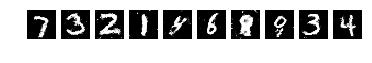

In [48]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー

gen_imgs_ = generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs_ + 0.5) * 1 #0,1にrescale
fig, axs = plt.subplots(1, 10)
for i in range(10):
    axs[i].axis('off')
    axs[i] = axs[i].imshow(gen_imgs[i, :,:,0], cmap='gray')

In [49]:
model = generator.layers[1]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 300)               30300     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 300)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 900)               270900    
__________

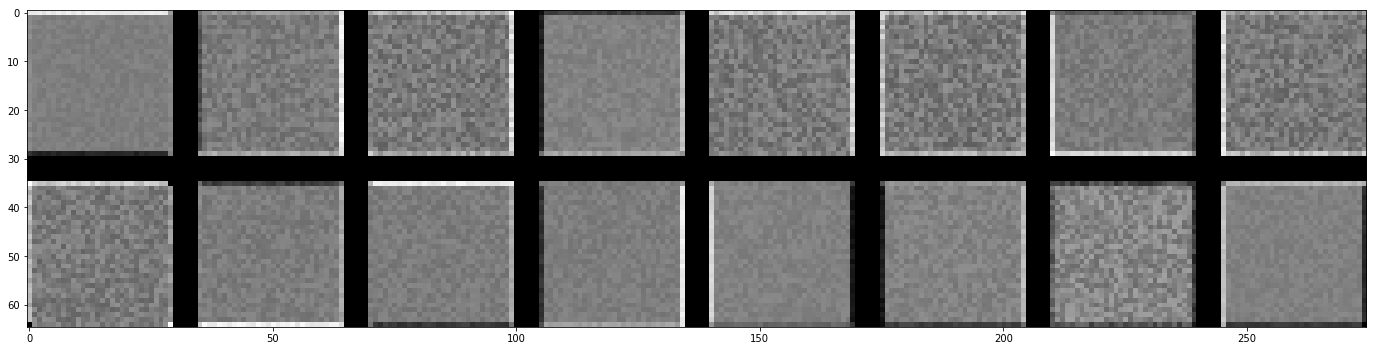

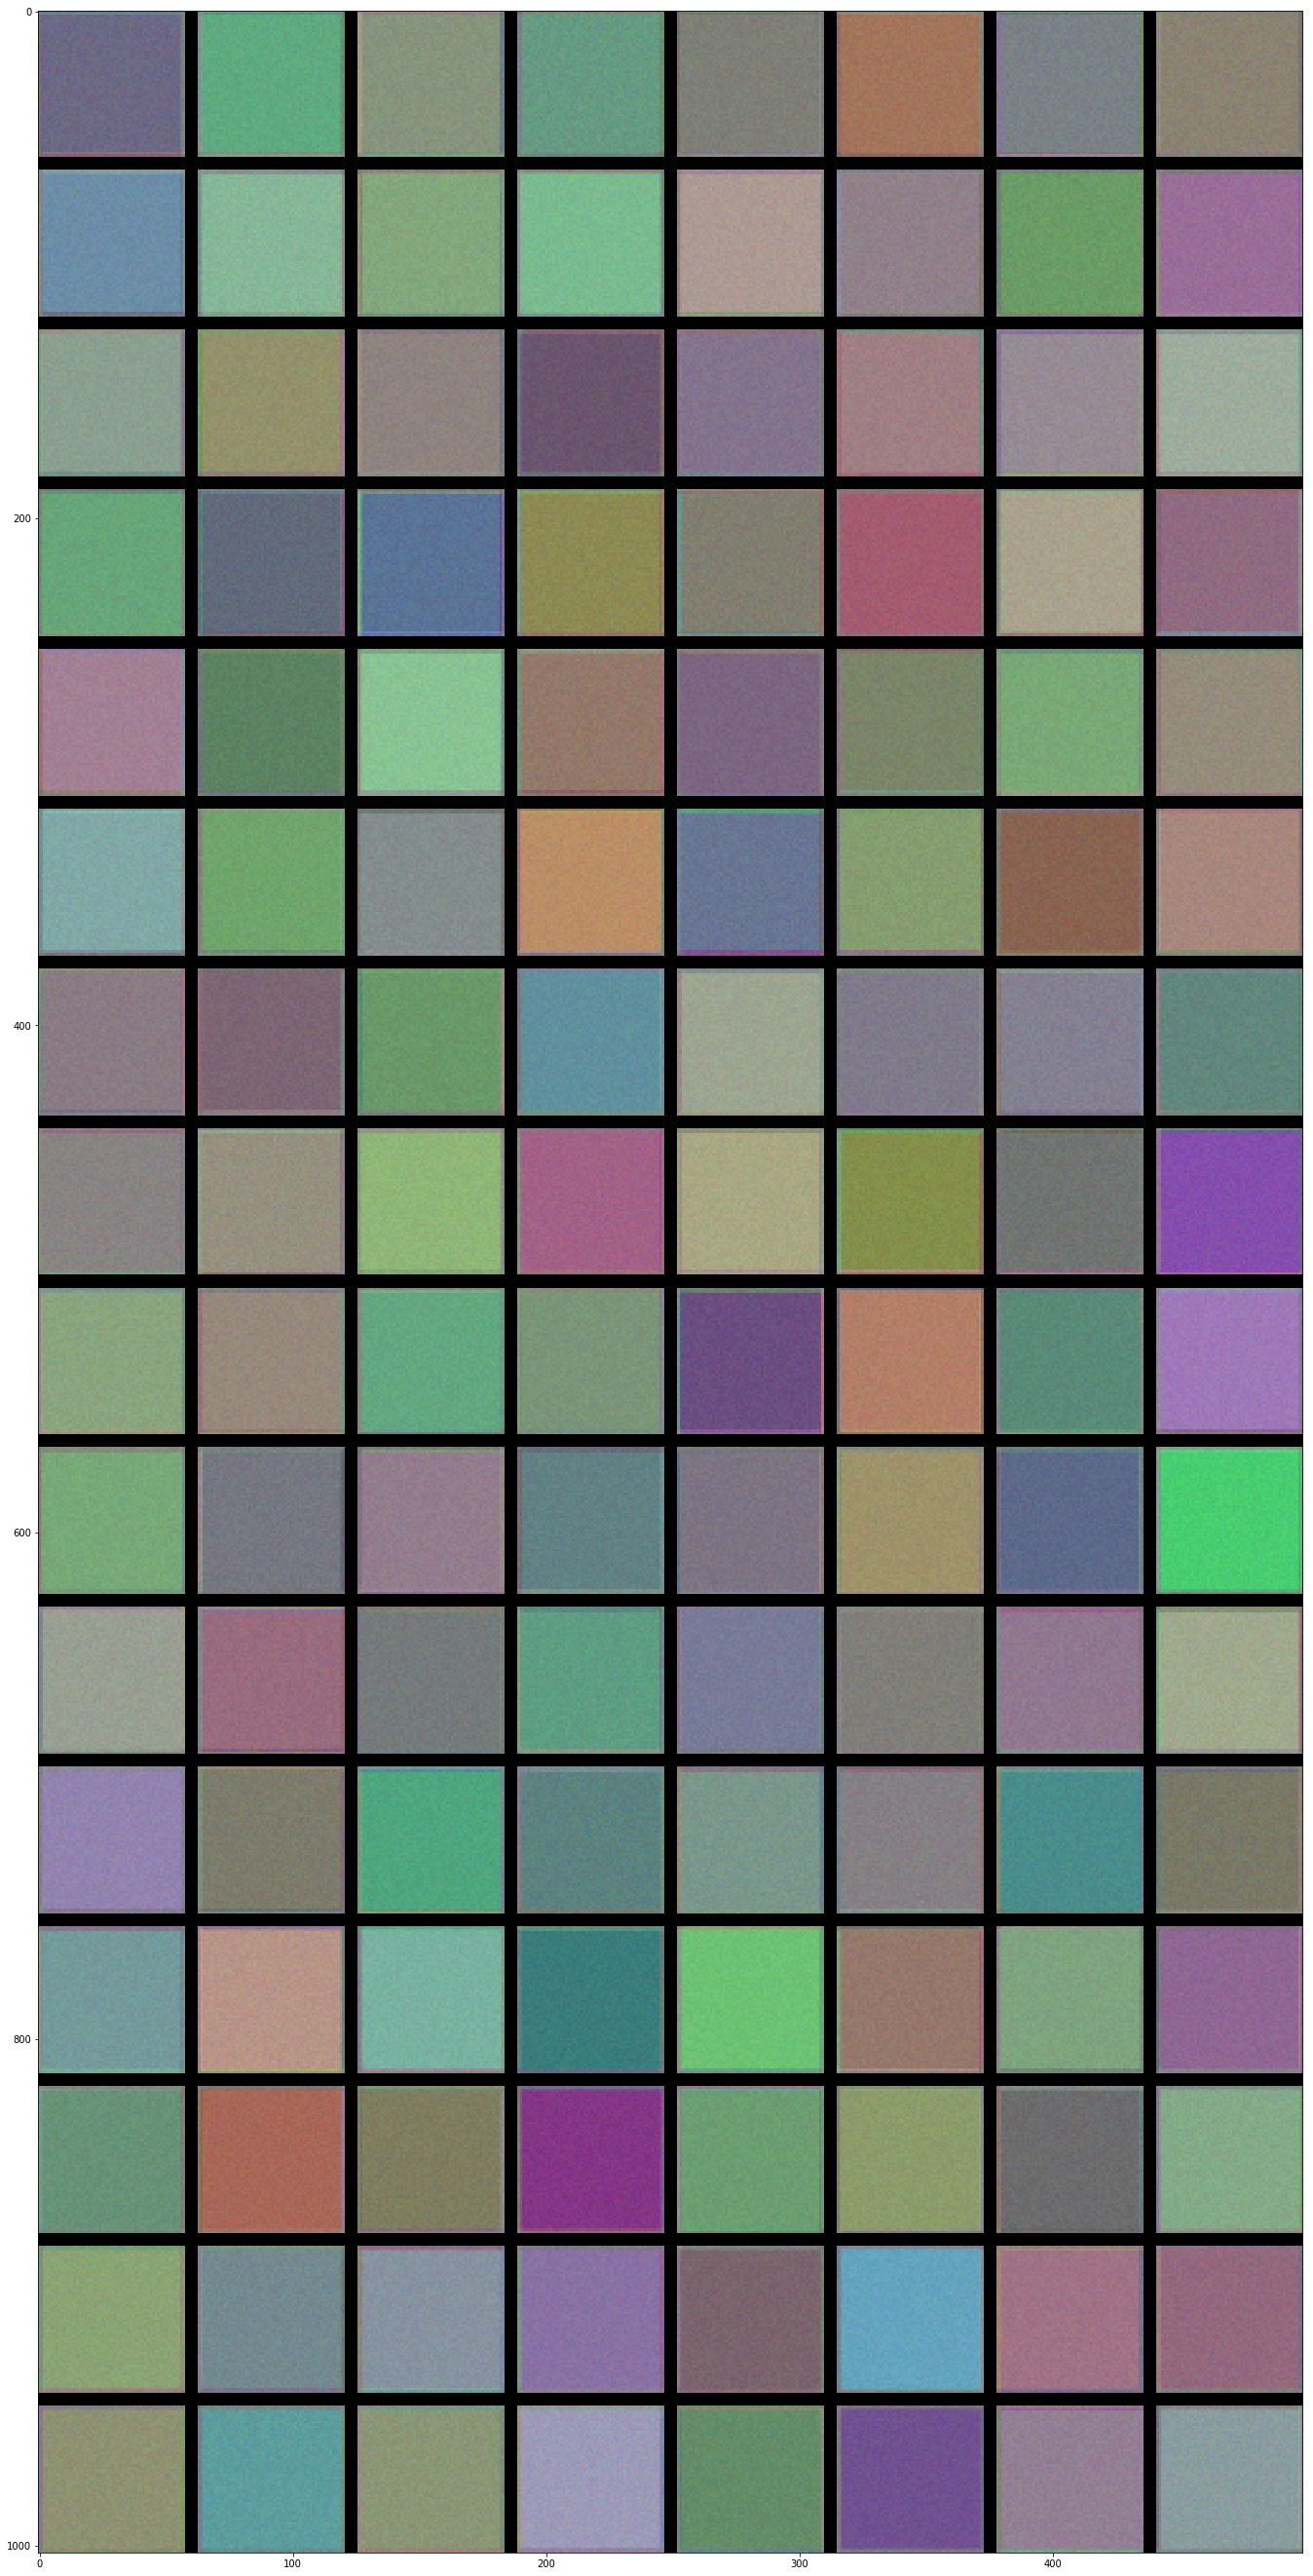

In [61]:
for layer_name in ['conv2d_1', 'conv2d_2']:
    visualize_layer(layer_name)